In [25]:
pip install pygris

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import pygris
import matplotlib.pyplot as plt

In [2]:
os.getcwd()

'C:\\Users\\olubl\\OneDrive\\14th grade\\PDEW_Predict'

In [2]:
#pull our pdew data and the geospatial dataframe pulled from the PDEW_eda script with city locations
all_pdew = pd.read_csv(f'{os.getcwd()}\\all_pdew_renamed.csv')
all_pdew = all_pdew[['city1','city2','nsmiles','passengers','fare','carrier_lg']]
all_cities_geo = gpd.read_file(f'{os.getcwd()}\\city_coords.geojson')

In [17]:
all_pdew.head() #our pdew counts by city pairs.

,city1,city2,nsmiles,passengers,fare,carrier_lg
0,"Allentown, PA","Dallas, TX",1307,18,367.69,AA
1,"Allentown, PA","Denver, CO",1539,89,138.60,G4
2,"Allentown, PA","Atlanta, GA",692,107,319.69,DL
3,"Allentown, PA","Austin, TX",1441,13,256.48,AA
4,"Allentown, PA","Nashville, TN",685,46,130.88,G4


In [18]:
all_cities_geo.head() #the rough geometry of each citymarket

,cityname,geometry
0,"Allentown, PA",POINT (-75.471 40.602)
1,"Dallas, TX",POINT (-96.797 32.776)
2,"Denver, CO",POINT (-104.98 39.739)
3,"Atlanta, GA",POINT (-84.39 33.754)
4,"Austin, TX",POINT (-97.744 30.271)


In [6]:
#descriptive stats for each numeric column
all_pdew.describe()

,nsmiles,passengers,fare
count,6611.000000,6611.000000,6611.000000
mean,1091.091514,203.439873,282.530593
std,584.066684,688.511938,79.852923
min,70.000000,10.000000,56.470000
25%,637.000000,18.000000,239.730000
50%,964.000000,36.000000,281.650000
75%,1471.000000,112.000000,327.310000
max,2783.000000,16339.000000,705.010000


In [6]:
all_cities_geo['geometry'].crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [7]:
#as one of the features of our model will be catchment population for each citymarket, we need to pull this data.
#we can use the package pygris to get population data for each csa
csa = pygris.combined_statistical_areas(year = '2020')   #this gets the geometry for each csa
csa = csa.to_crs('EPSG:4326')

HTTP download failed, trying FTP as fallback...


In [58]:
#now we can create a column for all_cities_geo that indicates the csa each citymarket is contained in
csa_overlay = gpd.overlay(all_cities_geo, csa, how = 'intersection')

In [66]:
csa_overlay.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 163 entries, 0 to 162
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   cityname  163 non-null    object  
 1   CSAFP     163 non-null    object  
 2   GEOID     163 non-null    object  
 3   NAME      163 non-null    object  
 4   NAMELSAD  163 non-null    object  
 5   LSAD      163 non-null    object  
 6   MTFCC     163 non-null    object  
 7   ALAND     163 non-null    int64   
 8   AWATER    163 non-null    int64   
 9   INTPTLAT  163 non-null    object  
 10  INTPTLON  163 non-null    object  
 11  geometry  163 non-null    geometry
dtypes: geometry(1), int64(2), object(9)
memory usage: 15.4+ KB


(23.0, 50.0)

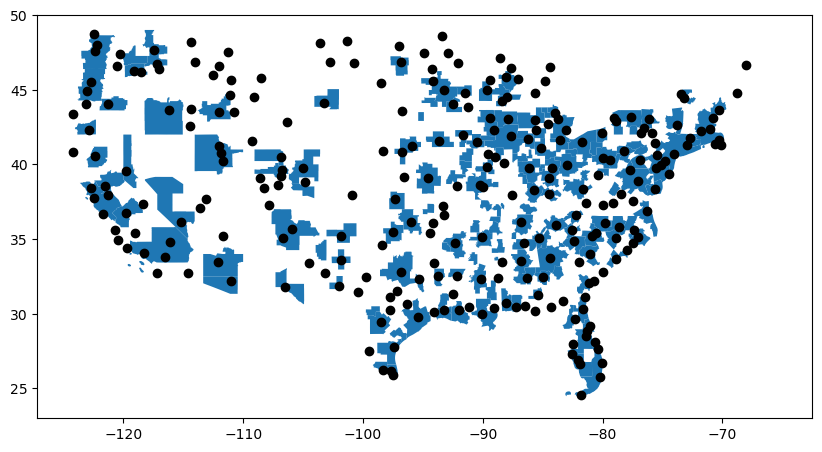

In [8]:
#only 163 of the 274 citymarkets are contained in some csa. let's plot these to get an idea where they are
fig, ax = plt.subplots(figsize = (10,13))

csa.plot(ax = ax)
all_cities_geo.plot(ax = plt.gca(), color = 'black')

ax.set_ylim(23,50)

In [3]:
#while we would prefer to use csas to better capture travel patterns, cbsas (of which there are 935, compared with 184 csas) will cover more of our data.
cbsa = pygris.core_based_statistical_areas(year = '2024').to_crs('EPSG:4326')
cbsa_overlay = gpd.overlay(all_cities_geo, cbsa, how = 'intersection')


HTTP download failed, trying FTP as fallback...


In [4]:
cbsa_overlay.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 269 entries, 0 to 268
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   cityname  269 non-null    object  
 1   CSAFP     172 non-null    object  
 2   CBSAFP    269 non-null    object  
 3   GEOID     269 non-null    object  
 4   GEOIDFQ   269 non-null    object  
 5   NAME      269 non-null    object  
 6   NAMELSAD  269 non-null    object  
 7   LSAD      269 non-null    object  
 8   MEMI      269 non-null    object  
 9   MTFCC     269 non-null    object  
 10  ALAND     269 non-null    int64   
 11  AWATER    269 non-null    int64   
 12  INTPTLAT  269 non-null    object  
 13  INTPTLON  269 non-null    object  
 14  geometry  269 non-null    geometry
dtypes: geometry(1), int64(2), object(12)
memory usage: 31.7+ KB


In [5]:
#this time we are only missing 5 citymarkets. let's see what those are:
cbsa_cities = pd.Series(cbsa_overlay['cityname'])
pdew_cities = pd.Series(all_cities_geo['cityname'])
pdew_cities[~pdew_cities.isin(cbsa_cities)].values

array(['Gunnison, CO', 'Rhinelander, WI', 'Presque Isle, ME',
       'Ashland, WV', 'International Falls, MN'], dtype=object)

In [6]:
#as expected, these are all tiny towns, so we opt to ignore them in the model
#let's get a look at the overlayed dataframe
cbsa_overlay.head()

,cityname,CSAFP,CBSAFP,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,MEMI,MTFCC,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,"Allentown, PA",106,10900,10900,310M700US10900,"Allentown-Bethlehem-Easton, PA-NJ","Allentown-Bethlehem-Easton, PA-NJ Metro Area",M1,1,G3110,3763301127,58254848,+40.7893392,-075.3981580,POINT (-75.471 40.602)
1,"Dallas, TX",206,19100,19100,310M700US19100,"Dallas-Fort Worth-Arlington, TX","Dallas-Fort Worth-Arlington, TX Metro Area",M1,1,G3110,22470698863,858023490,+32.8491708,-096.9704894,POINT (-96.797 32.776)
2,"Denver, CO",216,19740,19740,310M700US19740,"Denver-Aurora-Centennial, CO","Denver-Aurora-Centennial, CO Metro Area",M1,1,G3110,21612648987,149162547,+39.4347890,-104.9010728,POINT (-104.98 39.739)
3,"Atlanta, GA",122,12060,12060,310M700US12060,"Atlanta-Sandy Springs-Roswell, GA","Atlanta-Sandy Springs-Roswell, GA Metro Area",M1,1,G3110,22754281350,384413339,+33.7324018,-084.3928478,POINT (-84.39 33.754)
4,"Austin, TX",None,12420,12420,310M700US12420,"Austin-Round Rock-San Marcos, TX","Austin-Round Rock-San Marcos, TX Metro Area",M1,1,G3110,10929182221,150086251,+30.2497437,-097.6498417,POINT (-97.744 30.271)


In [9]:
#fetch population for each cbsa
cbsa_pop = pd.read_csv(os.path.join(os.getcwd(),'data','cbsa-est2024-alldata.csv'), encoding_errors = 'replace')
all_columns = cbsa_pop.columns.to_list()
cbsa_pop.head()

,CBSA,MDIV,STCOU,NAME,LSAD,ESTIMATESBASE2020,POPESTIMATE2020,POPESTIMATE2021,POPESTIMATE2022,POPESTIMATE2023,...,NETMIG2020,NETMIG2021,NETMIG2022,NETMIG2023,NETMIG2024,RESIDUAL2020,RESIDUAL2021,RESIDUAL2022,RESIDUAL2023,RESIDUAL2024
0,10180,NaN,NaN,"Abilene, TX",Metropolitan Statistical Area,176611,176926,177918,180072,182838,...,198,1161,2111,2457,1347,51,63,-26,3,-1
1,10180,NaN,48059.0,"Callahan County, TX",County or equivalent,13710,13753,14106,14275,14455,...,71,477,244,202,197,-6,-19,0,-2,-3
2,10180,NaN,48253.0,"Jones County, TX",County or equivalent,19663,19680,19903,20316,20765,...,26,373,464,489,163,6,-9,27,13,0
3,10180,NaN,48441.0,"Taylor County, TX",County or equivalent,143238,143493,143909,145481,147618,...,101,311,1403,1766,987,51,91,-53,-8,2
4,10420,NaN,NaN,"Akron, OH",Metropolitan Statistical Area,702211,701689,696602,698506,700094,...,-250,-3363,4405,3128,3399,196,216,-186,-148,3


In [12]:
#we are only concerned about 2024 values
list(filter(lambda substring: '2024' in substring, all_columns))

['POPESTIMATE2024',
 'NPOPCHG2024',
 'BIRTHS2024',
 'DEATHS2024',
 'NATURALCHG2024',
 'INTERNATIONALMIG2024',
 'DOMESTICMIG2024',
 'NETMIG2024',
 'RESIDUAL2024']

In [14]:
#filter for POPESTIMATE2024 and other columns of interest
#'CBSA' gives the index with which we can merge on with cbsa_overlay, and 'LSAD' gives the type (metro area, county, etc.)
cbsa_pop = cbsa_pop[['CBSA','NAME','LSAD','POPESTIMATE2024']]

In [15]:
#now let's merge this with our cbsa_overlay dataframe on the id (5-digit code for cbsas)
#check types of column
cbsa_overlay = cbsa_overlay.rename(columns = {'CBSAFP':'CBSA'})

print(f'population column type: {cbsa_pop['CBSA'].dtype}')
print(f'overlay column type: {cbsa_overlay['CBSA'].dtype}')

population column type: int64
overlay column type: object


In [16]:
#need to convert cbsa_overlay['CBSA'] to int
cbsa_overlay['CBSA'] = cbsa_overlay['CBSA'].astype(int)

In [17]:
#now we can merge the two dataframes
cbsa_geo = cbsa_overlay.merge(cbsa_pop, on = 'CBSA')
cbsa_geo.head()

,cityname,CSAFP,CBSA,GEOID,GEOIDFQ,NAME_x,NAMELSAD,LSAD_x,MEMI,MTFCC,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,NAME_y,LSAD_y,POPESTIMATE2024
0,"Allentown, PA",106,10900,10900,310M700US10900,"Allentown-Bethlehem-Easton, PA-NJ","Allentown-Bethlehem-Easton, PA-NJ Metro Area",M1,1,G3110,3763301127,58254848,+40.7893392,-075.3981580,POINT (-75.471 40.602),"Allentown-Bethlehem-Easton, PA-NJ",Metropolitan Statistical Area,886418
1,"Allentown, PA",106,10900,10900,310M700US10900,"Allentown-Bethlehem-Easton, PA-NJ","Allentown-Bethlehem-Easton, PA-NJ Metro Area",M1,1,G3110,3763301127,58254848,+40.7893392,-075.3981580,POINT (-75.471 40.602),"Warren County, NJ",County or equivalent,112031
2,"Allentown, PA",106,10900,10900,310M700US10900,"Allentown-Bethlehem-Easton, PA-NJ","Allentown-Bethlehem-Easton, PA-NJ Metro Area",M1,1,G3110,3763301127,58254848,+40.7893392,-075.3981580,POINT (-75.471 40.602),"Carbon County, PA",County or equivalent,65743
3,"Allentown, PA",106,10900,10900,310M700US10900,"Allentown-Bethlehem-Easton, PA-NJ","Allentown-Bethlehem-Easton, PA-NJ Metro Area",M1,1,G3110,3763301127,58254848,+40.7893392,-075.3981580,POINT (-75.471 40.602),"Lehigh County, PA",County or equivalent,385655
4,"Allentown, PA",106,10900,10900,310M700US10900,"Allentown-Bethlehem-Easton, PA-NJ","Allentown-Bethlehem-Easton, PA-NJ Metro Area",M1,1,G3110,3763301127,58254848,+40.7893392,-075.3981580,POINT (-75.471 40.602),"Northampton County, PA",County or equivalent,322989


In [67]:
#looks like some cbsas have multiple rows for different counties within the geographic area. we need to filter these out
#want to get the maximum population for each respective cityname value (this will be the total for the geographic area and give us 269 columns)

cbsa_filtered = cbsa_geo.copy()
for city in cbsa_filtered['cityname'].unique():
    max_pop = max(cbsa_filtered[cbsa_filtered['cityname'] == city]['POPESTIMATE2024'])
    mask = (cbsa_filtered['POPESTIMATE2024'] == max_pop) & (cbsa_filtered['cityname'] == city)
    mask_index = mask.idxmax() #only keep the first value
    to_keep = (mask & (mask.index == mask_index))| (cbsa_filtered['cityname'] != city)
    cbsa_filtered = cbsa_filtered[to_keep]


In [71]:
#and to check we still have 269 values:
cbsa_filtered.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 269 entries, 0 to 1322
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   cityname         269 non-null    object  
 1   CSAFP            172 non-null    object  
 2   CBSA             269 non-null    int32   
 3   GEOID            269 non-null    object  
 4   GEOIDFQ          269 non-null    object  
 5   NAME_x           269 non-null    object  
 6   NAMELSAD         269 non-null    object  
 7   LSAD_x           269 non-null    object  
 8   MEMI             269 non-null    object  
 9   MTFCC            269 non-null    object  
 10  ALAND            269 non-null    int64   
 11  AWATER           269 non-null    int64   
 12  INTPTLAT         269 non-null    object  
 13  INTPTLON         269 non-null    object  
 14  geometry         269 non-null    geometry
 15  NAME_y           269 non-null    object  
 16  LSAD_y           269 non-null    object 

In [73]:
#now let's check out the final dataframe we will be using for the model. 
#this dataframe has the cityname and cbsa name, core city geometry, and 2024 metro area population estimate.
columns = ['cityname','CBSA','NAME_x','NAMELSAD','geometry','POPESTIMATE2024']
model_data = cbsa_filtered[columns]
model_data.rename(columns = {'NAME_x':'NAME'})
model_data.head()

,cityname,CBSA,NAME_x,NAMELSAD,geometry,POPESTIMATE2024
0,"Allentown, PA",10900,"Allentown-Bethlehem-Easton, PA-NJ","Allentown-Bethlehem-Easton, PA-NJ Metro Area",POINT (-75.471 40.602),886418
5,"Dallas, TX",19100,"Dallas-Fort Worth-Arlington, TX","Dallas-Fort Worth-Arlington, TX Metro Area",POINT (-96.797 32.776),8344032
19,"Denver, CO",19740,"Denver-Aurora-Centennial, CO","Denver-Aurora-Centennial, CO Metro Area",POINT (-104.98 39.739),3052498
30,"Atlanta, GA",12060,"Atlanta-Sandy Springs-Roswell, GA","Atlanta-Sandy Springs-Roswell, GA Metro Area",POINT (-84.39 33.754),6411149
62,"Austin, TX",12420,"Austin-Round Rock-San Marcos, TX","Austin-Round Rock-San Marcos, TX Metro Area",POINT (-97.744 30.271),2550637


In [ ]:
#this is the clean dataframe we've been working towards!

In [15]:
geo_map = all_cities_geo.set_index('cityname')['geometry'].to_dict() #to do the mapping we need to make "cityname" be the indexing value.

In [ ]:
all_pdew['city1_geo'] = all_pdew['city1'].map(geo_map)
all_pdew['city2_geo'] = all_pdew['city2'].map(geo_map)

In [ ]:
#feature engineering with population gravity (log(city1 * city2))

In [ ]:
#baseline regression - gravity based